<a href="https://colab.research.google.com/github/ujjawalsingh10/Pytorch-Deep-Learning/blob/main/04_Custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Get Data

Food101 starts 101 different classes of food and 1000 images per class (750 training and 250 testing)

Our dataset starts with 3 classes of food and only 10% of images (`75 training and 25 testing)



In [3]:
import requests
import zipfile
from pathlib import Path

# setup path to the data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

## if the image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

## Download the data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
  print('Downloading the data...')
  f.write(request.content)


data/pizza_steak_sushi does not exist, creating one...


In [4]:
## unzipping the data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping...........')
  zip_ref.extractall(image_path)

Unzipping...........


## 2. Becoming one with the data (data preparation and exploration)

In [5]:
import os
def walkthrugh_dir(dir_path):
  """ walks thru directory and return its content """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [6]:
walkthrugh_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi


In [7]:
## Setup train and testing path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image
- pathlib.Path.parent.stem - to get the class name


data/pizza_steak_sushi/train/sushi/2720223.jpg
Image class: Sushi
Image height: 512
Image width: 512


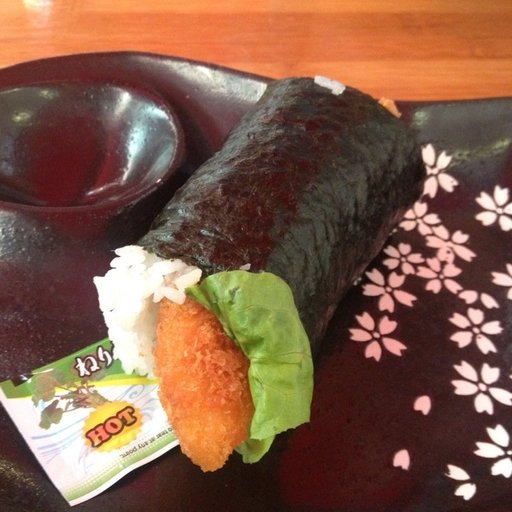

In [8]:
import random
from PIL import Image

# random.seed(42)

## get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

## pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

## get image class from path name (image class is the name of the directory)
image_class = random_image_path.parent.stem
print(f"Image class: {image_class.title()}")

## Open Image
img = Image.open(random_image_path)
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

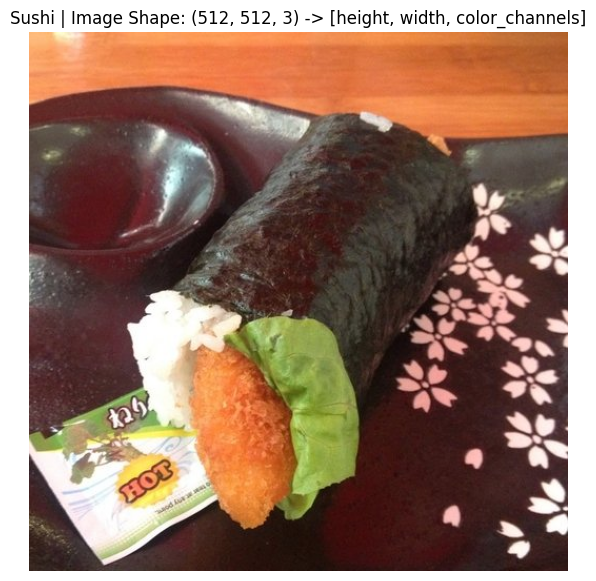

In [9]:
## visualizing the image using matplotlib
import matplotlib.pyplot as plt
import numpy as np

# turn image into array
img_as_array = np.asarray(img)

plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title(f"{image_class.title()} | Image Shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis('off');

## 3. Transforming Data
1. Turn data into tensors
2. turn into torch.utils.data.Dataset
3. and turn that into torch.utils.data.DataLoader.... we call these dataset and dataloader

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with torchvision.transforms

In [11]:
## write a transform for image
data_transform = transforms.Compose([
    ## resize iamges to 64x64
    transforms.Resize(size = (64, 64)),
    ## Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    ## Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  selects random images from path of iamges and loads/transforms
  then plots the original vs transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path_list, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")

      ## Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
      plt.show()


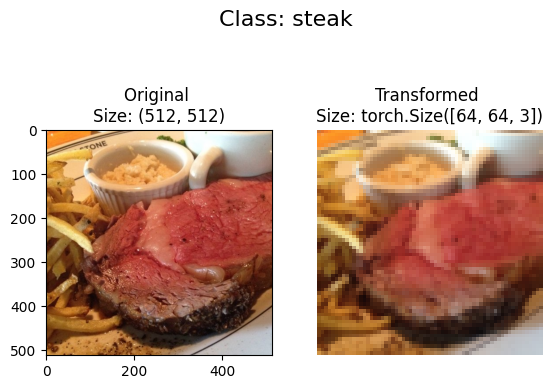

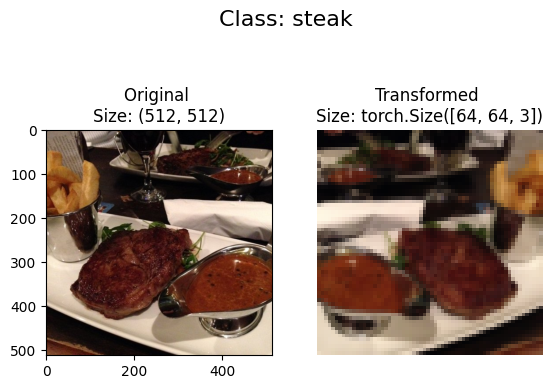

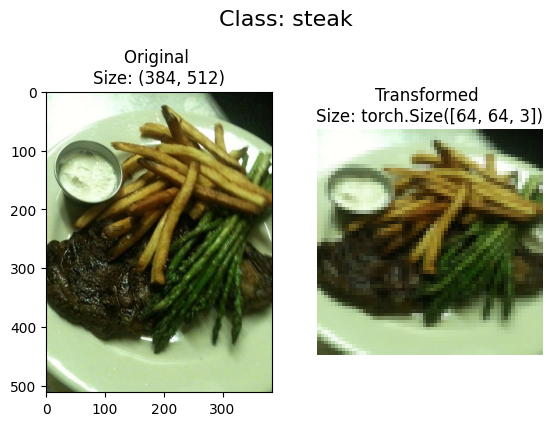

In [13]:
plot_transformed_images(image_path_list, data_transform)

## 4. Loading image data using ImageFolder

In [14]:
## use Image Folder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                  transform = data_transform,
                                  target_transform = None)

In [15]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
### get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
## check the length of the dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [20]:
## Index on train_data dataset to get a single image and label
img, label = train_data[0]

(-0.5, 63.5, 63.5, -0.5)

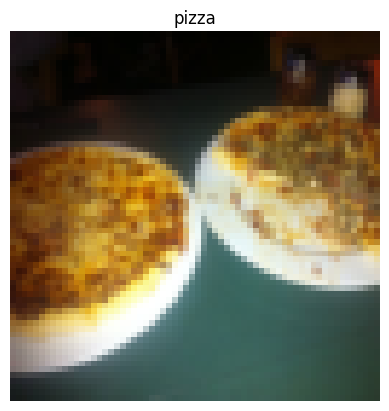

In [21]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')

## 4.1 Turning loaded images into dataloaders

In [22]:
import os
os.cpu_count()

2

In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size = BATCH_SIZE,
                            num_workers=os.cpu_count(),
                            shuffle = False)

In [24]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e77f482f6d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e77f4987a10>)

In [25]:
len(train_dataloader), len(test_dataloader)

(8, 3)

(-0.5, 63.5, 63.5, -0.5)

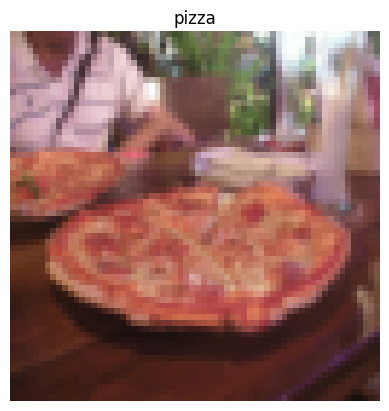

In [26]:
img, label = next(iter(train_dataloader))
plt.imshow(img[0].permute(1,2,0))
plt.title(class_names[label[0]])
plt.axis('off')

## 5. Option 2: Loading Image Data with a custom Dataset

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Dict, Tuple

In [28]:
## instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [29]:
# setup path directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

## get class names from the target directory
class_names_found = sorted(entry.name for entry in os.scandir(target_directory))
print(f"Class names found: {class_names_found}")

Target dir: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # 1. get the class names by scanning the target dir
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. raise error if class names not found
  if not classes:
    raise FileNotFoundError(f"Could not find any classes in {directory}")

  # 3. Create a dict of index labels
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom dataset to replicate `ImageFolder`

In [32]:
from torch.utils.data import Dataset

# 1.  Subclass it
class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform = None):
    # 2. Create Class attribute
    # get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. create a function to load images
  def load_image(self, index: int) -> Image.Image:
    " Opens an iamge via path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self):
    return len(self.paths)

  # 6. Overwrite __getitem__() to return particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    " returns one of data, data and label (X,y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx # ret untransformed image and label

In [33]:
## Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])

In [34]:
## Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                      transform = test_transforms)

In [35]:
len(train_data), len(train_data_custom)

(225, 225)

In [36]:
len(test_data), len(test_data_custom)

(75, 75)

In [37]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [38]:
train_data.classes == train_data_custom.classes

True

### 5.3 Create a function to display random images

In [39]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust disply if n is too high
  if n>10:
    n = 10
    display_shape = False
    print(f"For display purposes n should be less than 10, setting to {n}")

  # Set the seed
  if seed:
    random.seed(seed)

  # Get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # setup plot
  plt.figure(figsize = (16,8))

  # Loop thru random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample]

    # adjust tensor dimn for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # plot image
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust.squeeze())
    plt.axis('off')
    if classes:
      title = classes[targ_label]
      if display_shape:
        title = f"{title} \n Shape: {targ_image_adjust.shape}"
      plt.title(title)

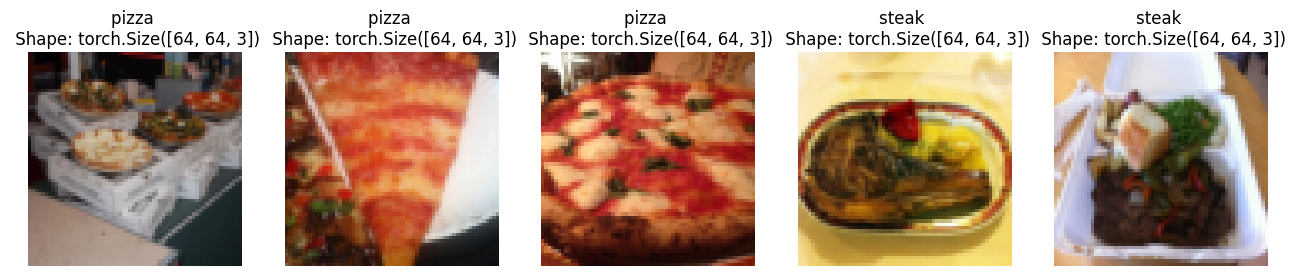

In [40]:
display_random_images(train_data_custom,
                      classes = train_data_custom.classes,
                      n = 5,
                      seed = 0)

### 5.4 Turn custom loaded images into dataloaders


In [41]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e77f3dae7d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e77f3cb1390>)

## 6. Other forms of transforms(Data Augmentation)

In [42]:
## Trivial augment

train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [43]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/steak/3577618.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2129685.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1598345.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/2606444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/922752.jpg')]

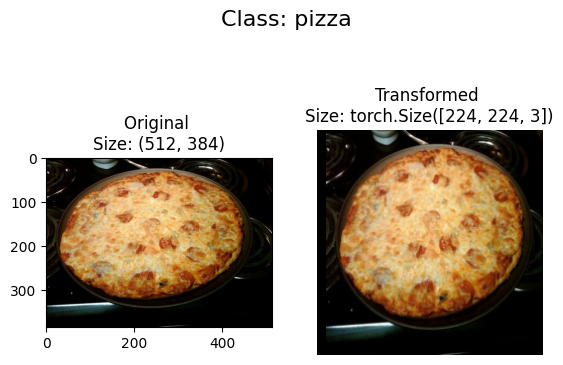

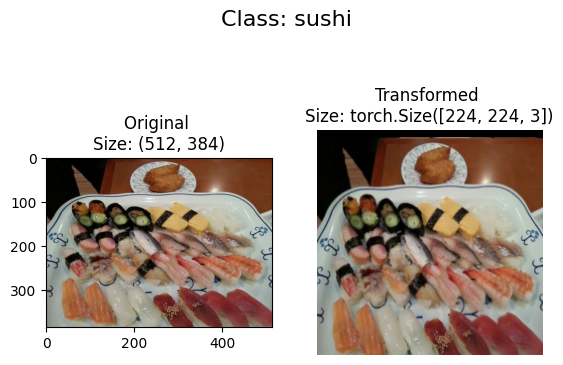

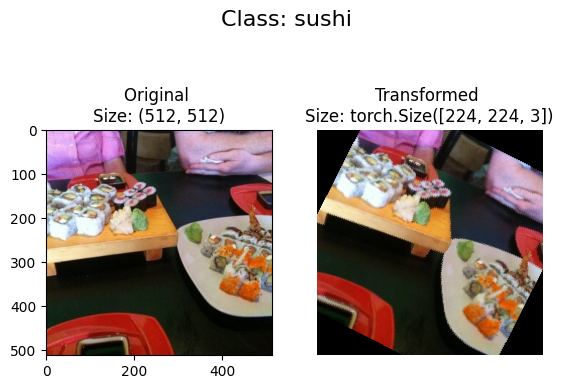

In [44]:
# plot random tranformed images
plot_transformed_images(image_path_list, train_transform)

## 7 Model_0 :  TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for model 0

In [45]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.ToTensor()
])


In [46]:
## Load and transform data

from torchvision import datasets

train_data_simple = datasets.ImageFolder(root = train_dir,
                          transform = simple_transform,
                          target_transform = None)

test_data_simple = datasets.ImageFolder(root = test_dir,
                          transform = simple_transform,
                          target_transform = None)

## Turn the datasets into DataLoaders
from torch.utils.data import DataLoader
import os

# Batch size and no of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                batch_size = BATCH_SIZE,
                shuffle = True,
                num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                batch_size = BATCH_SIZE,
                shuffle = False,
                num_workers = NUM_WORKERS)

### 7.2 Create TinyVGG model Class

In [47]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units * 13 * 13,
                  out_features = output_shape),
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # x = self.classifier(x)
    # return x

In [48]:
torch.manual_seed(42),
model_0 = TinyVGG(input_shape=3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 try a forward pass on a single image (to test model)

In [49]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [51]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [52]:
from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Train and test loops

In [55]:
## Create train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
  # put the model in train mode
  model.train()

  # setup train loss and train acc values
  train_loss, train_acc = 0, 0

  # Loop through the data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # calc loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    ## optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()

    ## cal acc
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim = 1)
    train_acc += ((y_pred_class ==y).sum().item()/len(y_pred))

  # adjust metrics to get average loss and acc per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [62]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device = device):
  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    # loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_label = test_pred_logits.argmax(dim = 1)
      test_acc += ((test_pred_label == y).sum().item()/len(test_pred_label))

    # av loss and acc
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



### creating a train() fxn to combine train_step and test_step

In [63]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # create empty results dict
  results = {
      'train_loss' : [],
      'train_acc' : [],
      'test_loss' : [],
      'test_acc' : []
  }

  # Loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)
    ## print out
    print(f"Epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

    # update dict
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results

### 7.7 Training and evaluating the model

In [64]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

# recreate instance of tinyvgg
model_0 = TinyVGG(input_shape=3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

## loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.001)

## start the timer
from timeit import default_timer as timer

start_time = timer()

# train model 0
model_0_results = train(model=model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 1 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 3 | train_loss: 1.0842 | train_acc: 0.3984 | test_loss: 1.0608 | test_acc: 0.5833
Epoch: 4 | train_loss: 1.0662 | train_acc: 0.4141 | test_loss: 1.0654 | test_acc: 0.5644
Total training time: 9.779 seconds


In [65]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333287000656,
  1.0662163645029068],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608318249384563,
  1.0653960307439168],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 PLot the loss curves of MOdel 0

In [70]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [71]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of results dictionary"""
  # get the loss values
  loss = results['train_loss']
  test_loss = results['test_loss']

  # get the acc values
  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  # find the no of epochs
  epochs = range(len(results['train_loss']))

  # setup the plot
  plt.figure(figsize=(15,7))

  # plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='Train loss')
  plt.plot(epochs, test_loss, label = 'Test loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # plot the acc
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='Train accuracy')
  plt.plot(epochs, test_accuracy, label = 'Test accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  plt.show()

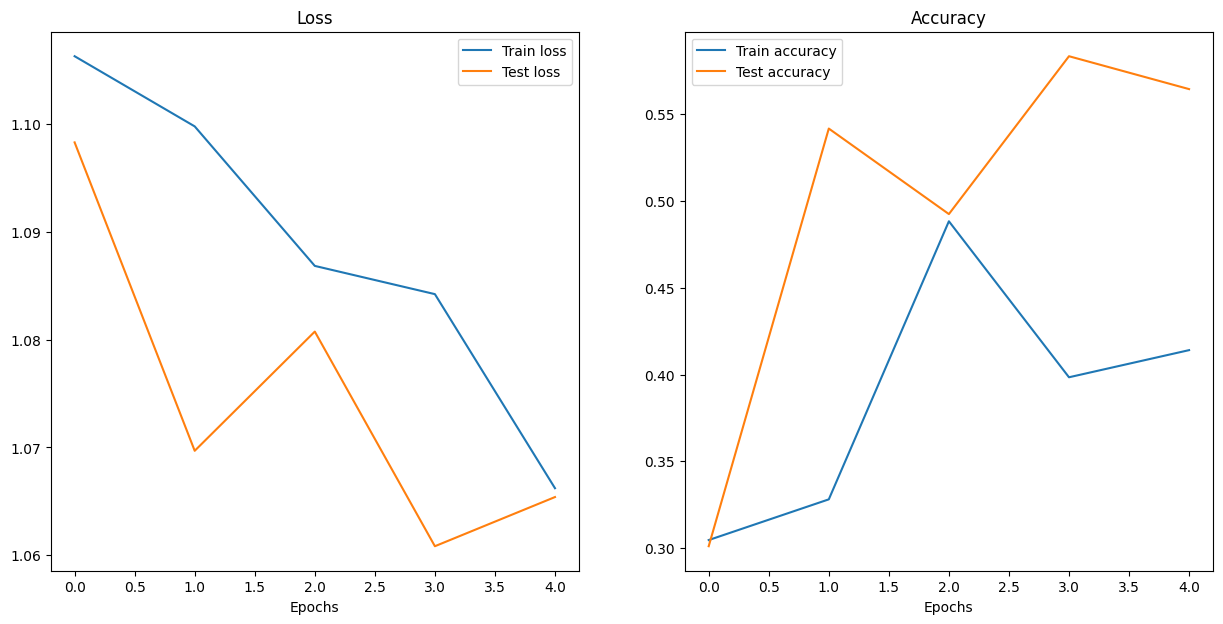

In [72]:
plot_loss_curves(model_0_results)

## 9 Model 1 : TinyVGG with data augmentation

In [75]:
# create training transform with Trivial augmentation
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# create test transform
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

## 9.2 Create train and test datasets and dataloaders with data augmentation

In [78]:
# turn image folders into datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform = train_transform_trivial)
test_data_augmented = datasets.ImageFolder(root=test_dir,
                                           transform = test_transform_simple)

In [82]:
# Turn dataset into dataloaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                batch_size = BATCH_SIZE,
                num_workers = NUM_WORKERS,
                shuffle = True)
test_dataloader_augmented = DataLoader(dataset=test_data_simple,
                 batch_size = BATCH_SIZE,
                 num_workers = NUM_WORKERS,
                 shuffle = False)

In [83]:
len(train_dataloader_augmented), len(test_dataloader_augmented)

(8, 3)

### 9.3 Construct and train model 1 ( same model but augmented data)

In [84]:
# create model 1 and send it to device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units = 10,
                  output_shape = len(train_data_augmented.classes)).to(device)

In [85]:
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [88]:
## setup loss fxn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

## start the timer
from timeit import default_timer as timer
start_time = timer()

## Train Model 1
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 1.1049 | train_acc: 0.2500 | test_loss: 1.1019 | test_acc: 0.2604
Epoch: 1 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1261 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0712 | train_acc: 0.4258 | test_loss: 1.1593 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1253 | train_acc: 0.3047 | test_loss: 1.1581 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0865 | train_acc: 0.4258 | test_loss: 1.1554 | test_acc: 0.3333
Total training time: 10.454 seconds


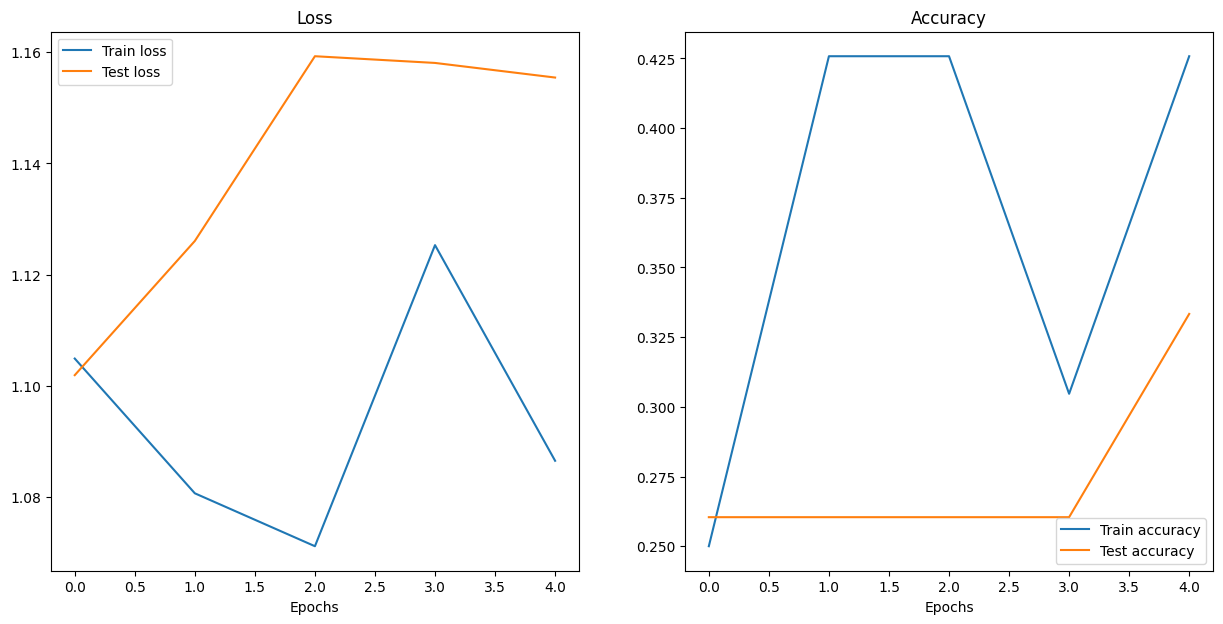

In [89]:
plot_loss_curves(model_1_results)

## 10. Compare model results
1. Hard coding ( what we doing)
2. Pytorch + Tensorboard
3. Weights and Biases
4. MLFlow

In [90]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


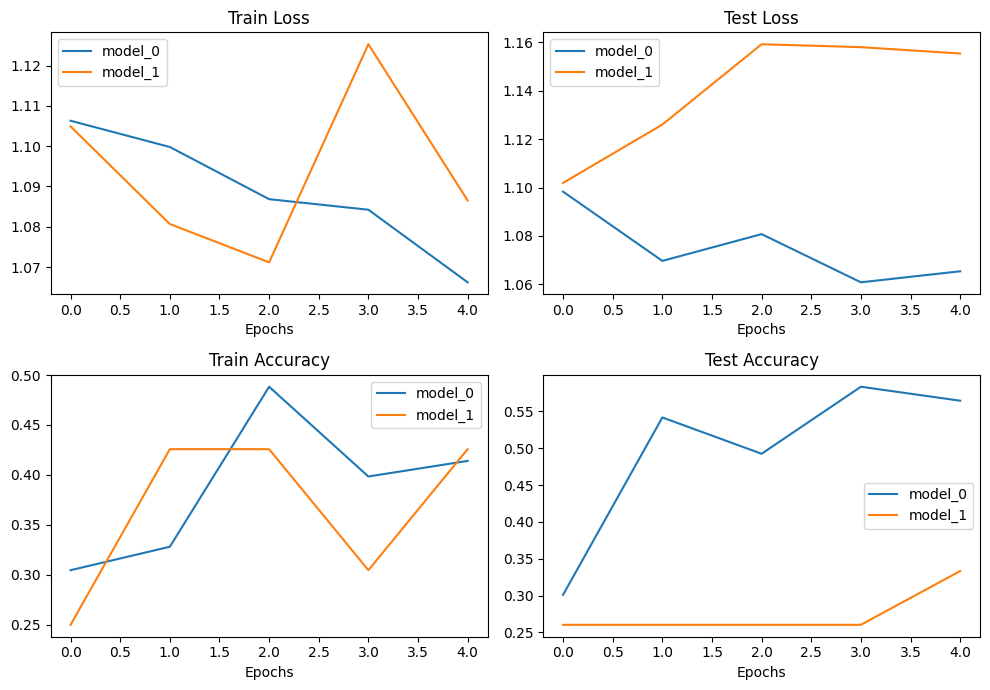

In [95]:
# setup a plot
plt.figure(figsize = (10, 7))

# get no of epochs
epochs = range(len(model_0_df))

## plot the train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label = 'model_0')
plt.plot(epochs, model_1_df['train_loss'], label = 'model_1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

## plot the test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label = 'model_0')
plt.plot(epochs, model_1_df['test_loss'], label = 'model_1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

## plot the train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label = 'model_0')
plt.plot(epochs, model_1_df['train_acc'], label = 'model_1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

## plot the test loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label = 'model_0')
plt.plot(epochs, model_1_df['test_acc'], label = 'model_1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.tight_layout();

## 11. Making a prediction on custom image

In [107]:
## download a custom image
import requests

# setup custom image path
custom_image_path = data_path / 'custom_image.jpeg'

# download the image if it does not exist already
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    response = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
    print(f"Downloading {custom_image_path}")
    f.write(response.content)
else:
  print(f"{custom_image_path} already exists, skipping download..")

### 11.1 Loading custom image with pytorch

 make the image of same shape as our model is trained on

1. tensor with dataype float32
2. of shape 64x64
3. on right device

In [114]:
import torchvision as tv

# read in custom image
custom_image = tv.io.read_image(custom_image_path)
custom_image

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

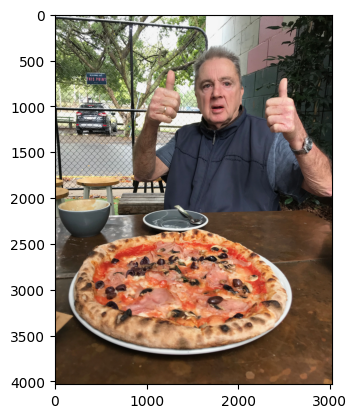

In [115]:
plt.imshow(custom_image.permute(1,2,0))

### 11.2 Making a prediction on a custom image with a trained pytorch model

In [120]:
# loading the image and convert to float32
custom_image = tv.io.read_image(custom_image_path).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

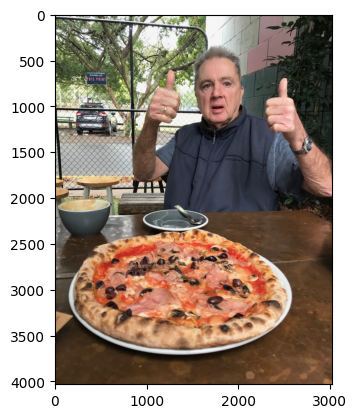

In [121]:
plt.imshow(custom_image.permute(1,2,0))

In [123]:
# Create a transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

## transform target image
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed

tensor([[[0.4673, 0.5292, 0.5601,  ..., 0.0976, 0.0604, 0.0578],
         [0.4014, 0.4351, 0.4291,  ..., 0.0671, 0.0714, 0.0848],
         [0.5172, 0.4849, 0.4472,  ..., 0.0613, 0.0605, 0.0694],
         ...,
         [0.2999, 0.2819, 0.2705,  ..., 0.4570, 0.4019, 0.3955],
         [0.2767, 0.2697, 0.2606,  ..., 0.4620, 0.4208, 0.3763],
         [0.2502, 0.2557, 0.2690,  ..., 0.4894, 0.6088, 0.5344]],

        [[0.4926, 0.5517, 0.5773,  ..., 0.1246, 0.0688, 0.0680],
         [0.4545, 0.4876, 0.4600,  ..., 0.0806, 0.0824, 0.1022],
         [0.5485, 0.5217, 0.4785,  ..., 0.0689, 0.0704, 0.0882],
         ...,
         [0.2066, 0.1971, 0.1882,  ..., 0.3125, 0.2772, 0.2778],
         [0.1922, 0.1870, 0.1805,  ..., 0.3217, 0.2926, 0.2662],
         [0.1730, 0.1777, 0.1865,  ..., 0.3425, 0.4223, 0.3684]],

        [[0.4510, 0.5250, 0.5622,  ..., 0.0806, 0.0408, 0.0439],
         [0.3132, 0.3614, 0.3848,  ..., 0.0508, 0.0532, 0.0766],
         [0.4766, 0.4248, 0.3951,  ..., 0.0463, 0.0469, 0.

In [125]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

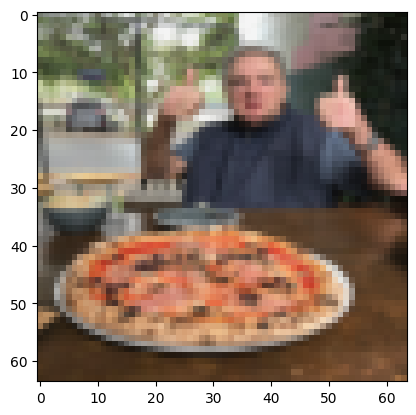

In [127]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [128]:
# ## Error cuz of batch size
# model_1.eval()
# with torch.inference_mode():
#   custom_image_pred = model_1(custom_image_transformed).to(device)

In [133]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0)).to(device)
custom_image_pred

tensor([[ 0.0781,  0.0379, -0.2067]])

In [134]:
## convert logits into probs
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.3686, 0.3541, 0.2773]])

In [135]:
# convert prob prob to pred label
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim = 1)
custom_image_pred_labels

tensor([0])

In [136]:
class_names[custom_image_pred_labels]

'pizza'

### 11.3 Putting custom image prediction together: building a function

In [140]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  # loading the image
  target_image = tv.io.read_image(image_path).type(torch.float32)

  # get the image pixel values bw 0 and 1
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # make sure the model is on target device
  model.to(device)

  # turn on eval/pred mode and make a pred
  model.eval()
  with torch.inference_mode():
    # add an extra dim to image, batch dim.. to predict on batches of 1 image
    target_image = target_image.unsqueeze(0)

    # make pred
    target_image_pred = model(target_image.to(device))

    # convert logits to probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

    # convert probs to labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

    # plot image
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
      title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title(title)
    plt.axis(False);


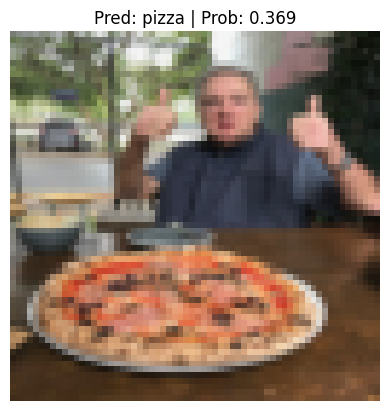

In [141]:
pred_and_plot_image(model=model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)